In [287]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

import matplotlib.pyplot as plt

In [288]:
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

In [289]:
class safe_AwACI(AdaptiveCP):
    def set_loss(self, optimal_set, given_set):
         val = (optimal_set - given_set) 
         if val < 0:
              return (self.coverage_target) * (-1* val)
         else:
              return (1 - self.coverage_target) * val
    
    def set_loss_vectorize(self):
         return np.vectorize(self.set_loss)
    
    def ACI_head(self, timeseries_data: tuple, gamma: float, start_point: int, custom_interval = None):
        xpred, y = timeseries_data
        alpha_t_list = [self.coverage_target]

        All_scores = self.score_function(xpred, y)

        err_t_list = []
        conformal_sets_list = []
        
        for i in range(start_point, len(All_scores)):
            Coverage_t = self.C_t(alpha_t_list[-1], All_scores, xpred[i], i, custom_interval)
            conformal_sets_list.append(Coverage_t)

            # We calculate the optimal B_t.

            yield Coverage_t

            error_t = AdaptiveCP.err_t(y[i], Coverage_t)
            err_t_list.append(error_t)

            alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            alpha_t_list.append(alpha_t)

        return False
    
    def AwACI(self, timeseries_data: tuple, interval_candidates: np.array = None, nu_sigma: tuple = (10**-2, 0.05), gamma: float = 0.05, title: str = None):
        
        xpred, y = timeseries_data

        chosen_interval_index = []
        err_t_list = []
        conformal_sets_list = []
        optimal_radius_list = []
        chosen_radius_list = []

        all_head_radii = []
        all_interval_weights = []



        Set_loss = self.set_loss_vectorize()

        # Scale parameters, havent looked into scaling them best.
        sigma = nu_sigma[1]
        nu = nu_sigma[0] 

        if interval_candidates is None:
            interval_candidates = np.array(range(50, 550, 100))

        # To sync all of the heads we need to start at the max of all the candidates.
        start_point = max(interval_candidates) + 1
        i_count = start_point

        # Create the head and intitialse the weights.
        ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
        interval_weights = np.ones(len(interval_candidates))
        culmative_loss = np.zeros(len(interval_candidates))
        
        # Continues calculating intervals until one of the heads stops.
        none_terminated = True

        while none_terminated: 
            head_sets = [] # Will contain the result from each head.
                
            try:
                # Create a list of the coverages for the different heads.
                for head in ACI_heads:
                        head_sets.append(next(head))
            
            except StopIteration: # One head is terminated.
                none_terminated = False
                break # You could but the return statement here

            # Choosing which head to use.
            try:
                chosen_set = random.choices(head_sets, weights=interval_weights, k=1)[0] # Using random module as numpy can not deal with tuples.
            except ValueError:
                print(all_interval_weights[-5:])
                raise ValueError('Interval probabilities are not normalised correctly.')
            
            conformal_sets_list.append(chosen_set)
            chosen_interval_index.append(head_sets.index(chosen_set))

             # TIME FRONTIER -------------

            # Seeing whether result lies within the set.
            err_true = AdaptiveCP.err_t(y[i_count], chosen_set)

            # Computing the conformal set radi. 
            optimal_set_radius = abs(y[i_count] - y[i_count-1]) ### Added abs as this shoudl always be positive. however still has seemed to change anything
            
            head_set_radius = list(map(lambda Cset: (Cset[1] - Cset[0])/2, head_sets)) #(chosen_set[1] - chosen_set[0])/2
            head_set_radius = np.array(head_set_radius)
            
            # Calculating the loss.
            culmative_loss += Set_loss(optimal_set_radius, head_set_radius)

            # Updating the weights.
            new_weights = interval_weights * np.exp(-1 * nu * culmative_loss) # log space
            final_weights = new_weights*(1-sigma) + (new_weights.mean() *sigma) # mean
            
            interval_weights = final_weights/sum(final_weights)


            # Incrementing the i-count
            i_count+=1

            # Appending the results to the lists.
            err_t_list.append(err_true)
            chosen_radius_list.append((chosen_set[1] - chosen_set[0]/2)) 
            optimal_radius_list.append(optimal_set_radius)
            all_head_radii.append(head_set_radius)
            all_interval_weights.append(interval_weights)

        # Calculating different averages
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
        average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

        return {
                'model': title if title is not None else 'safe AwACI',
                'coverage_target': self.coverage_target,
                'interval_candidates': interval_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'optimal_set_radius': optimal_radius_list, 
                'chosen_set_radius': chosen_radius_list,
                'all_head_radii': all_head_radii,
                'all_weights': all_interval_weights,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'chosen_interval_index': chosen_interval_index,
                'start_point': start_point,
                'interval_size': 50
            }


In [290]:
ACP = safe_AwACI(0.1)
generic_ACP = AdaptiveCP(0.1)

In [291]:
normal_data = ACP_data.random_multi_shift(10, (5000,5001))[0]

In [292]:
result = ACP.AwACI(normal_data)

In [293]:
nresult = generic_ACP.AwACI(normal_data, nu_sigma=(10**-6, 0.01))

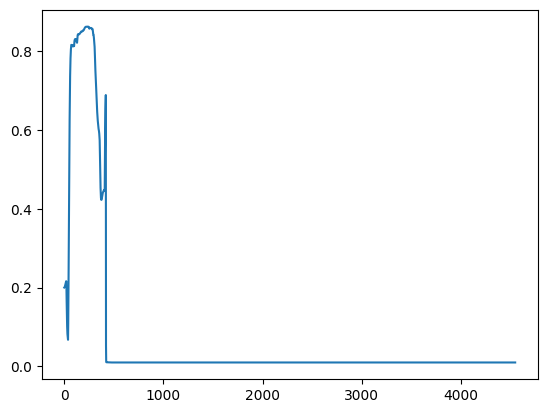

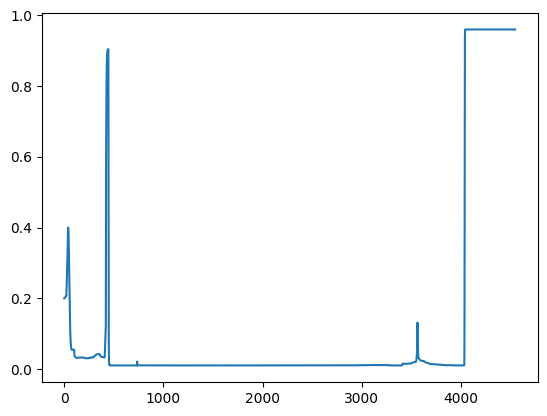

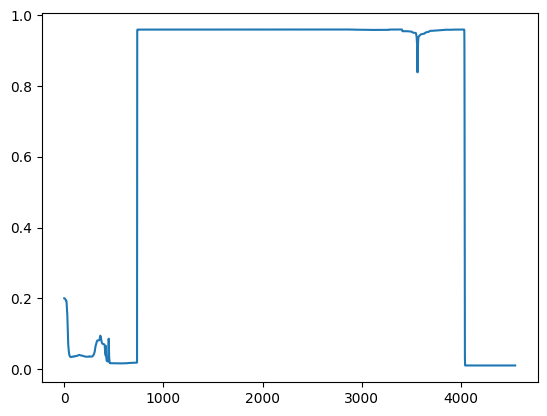

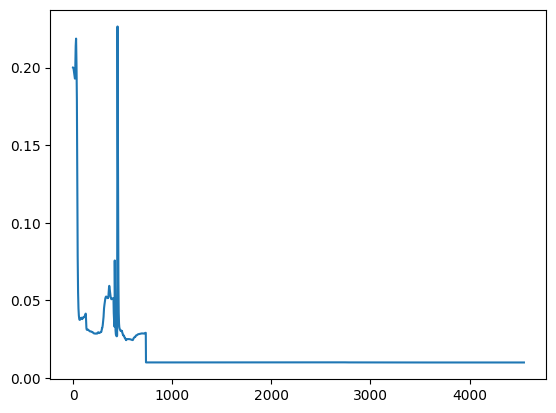

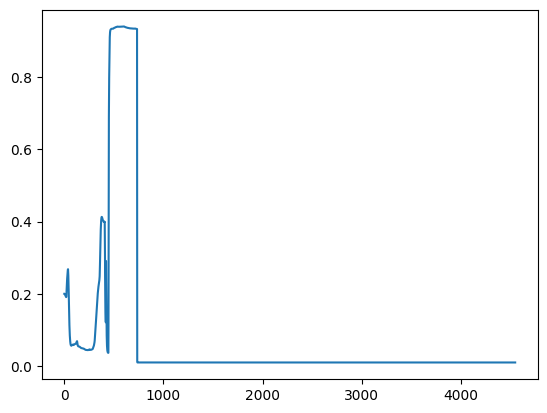

In [294]:
weights = result['all_weights']

for i in range(len(weights[0])):
    plt.plot([x[i]/sum(x) for x in weights])
    plt.show()

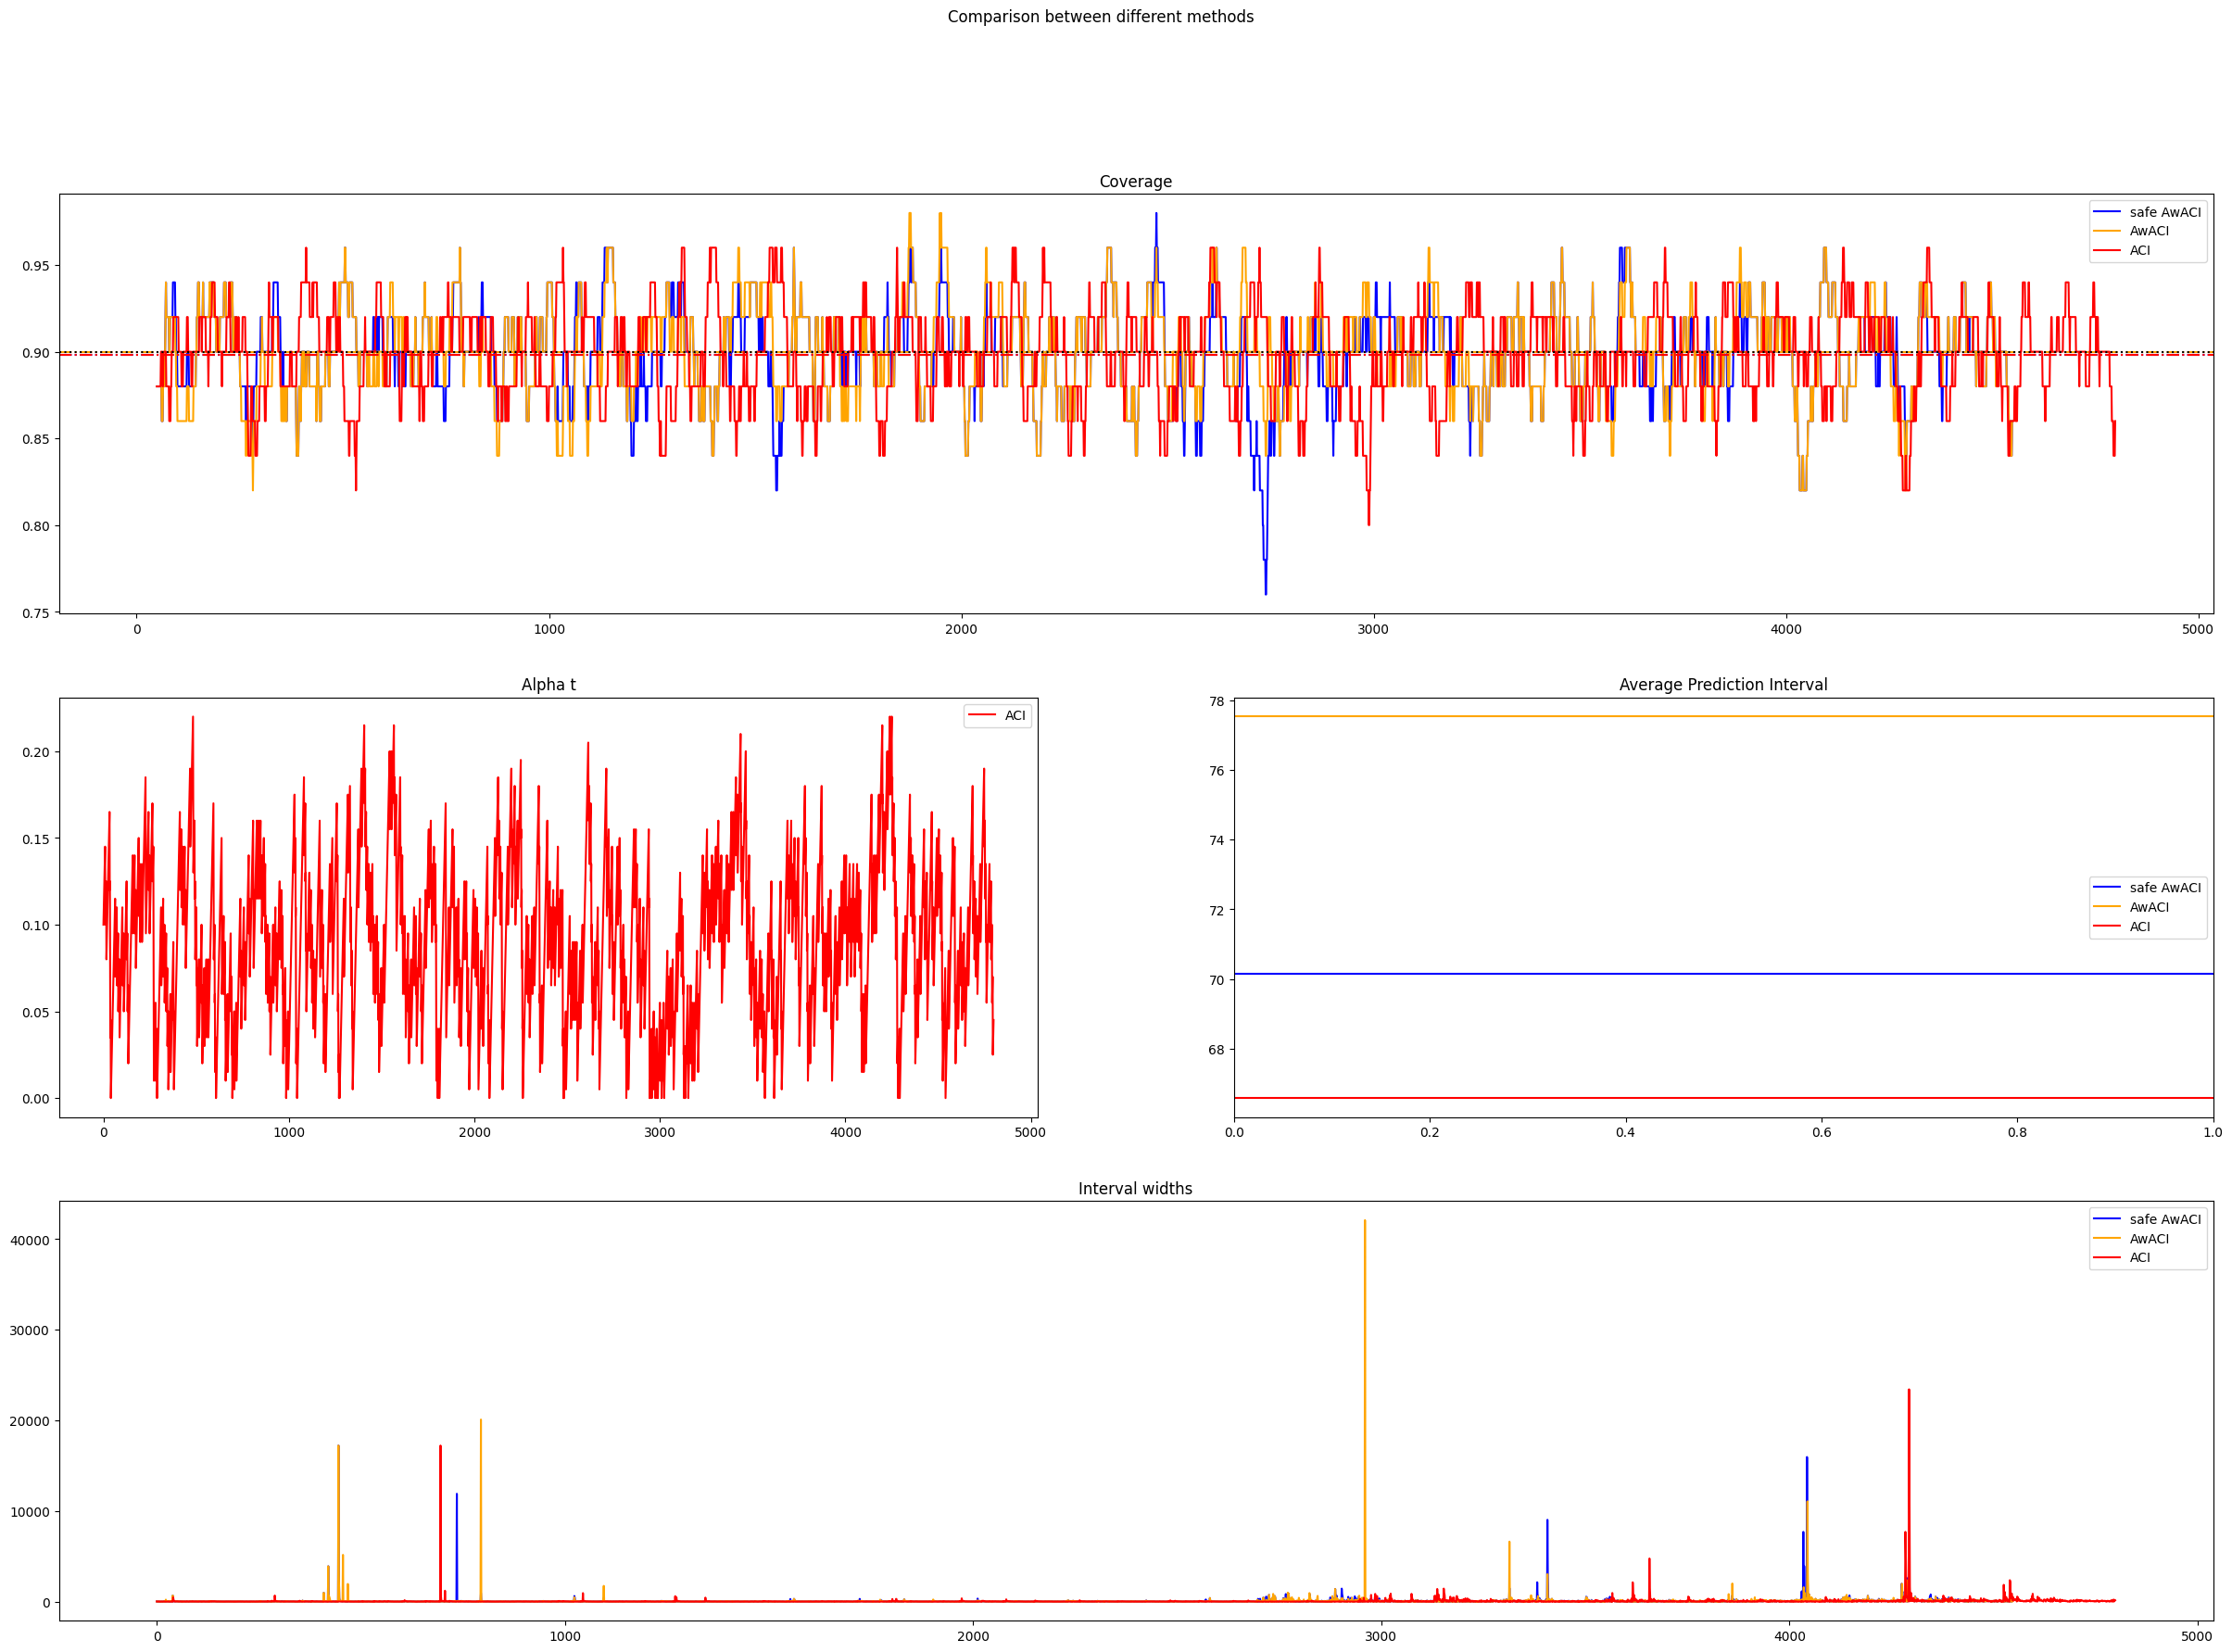

In [295]:
ACP_plots.compare_many([result, nresult, generic_ACP.ACI(normal_data, 0.05, 200)], (30,20))

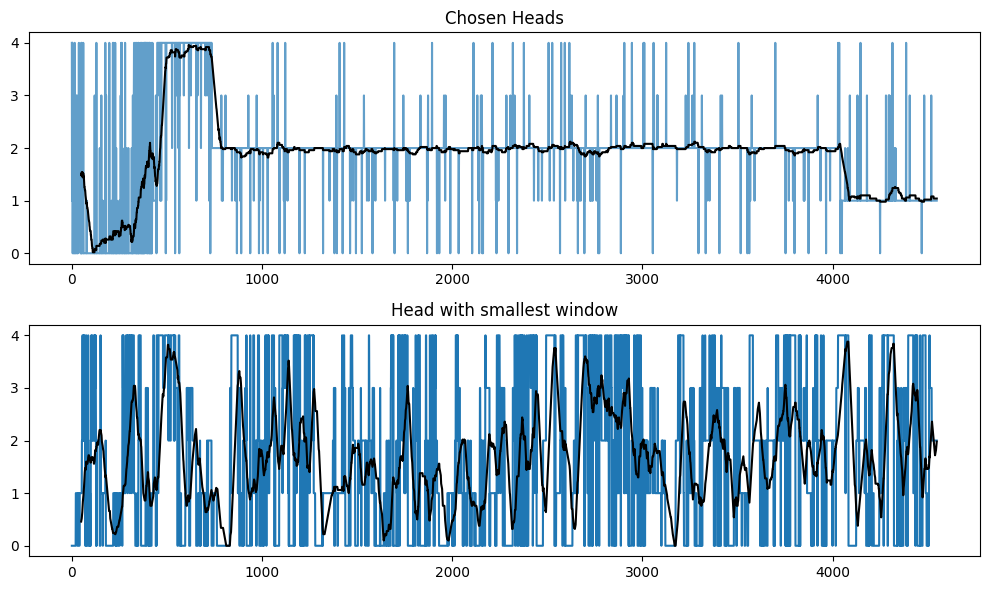

In [296]:
# Plotting the chosen heads vs the head with the lowest loss.
# Making the plots slightly transparent
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(result['chosen_interval_index'], alpha=0.7)
rolling_mean = pd.Series(result['chosen_interval_index']).rolling(50).mean()
plt.plot(rolling_mean, alpha=1, color='black')
plt.title('Chosen Heads')
plt.subplot(2, 1, 2)
plt.plot(np.array(result['all_head_radii']).argmin(axis=1), alpha=1)
rolling_mean = pd.Series(np.array(result['all_head_radii']).argmin(axis=1)).rolling(50).mean()
plt.plot(rolling_mean, alpha=1, color='black')
plt.title('Head with smallest window')
plt.tight_layout()
plt.show()


In [300]:
vanila_dict = {'coverge':[], 'width':[]}
inverse_dict = {'coverge':[], 'width':[]}

for i, data in enumerate(ACP_data.random_multi_shift(100, (5000,5001))):
    vanila = generic_ACP.AwACI(data, nu_sigma=(10**-3, 0.05))
    adapted = ACP.AwACI(data, nu_sigma=(10**-3, 0.05))

    vanila_dict['coverge'].append(vanila['realised_interval_coverage'])
    vanila_dict['width'].append(vanila['average_prediction_interval'])

    inverse_dict['coverge'].append(adapted['realised_interval_coverage'])
    inverse_dict['width'].append(adapted['average_prediction_interval'])

    if i % 10 == 0:
        print(i)

# Computing the averages and printing.
vanila_coverage = np.mean(vanila_dict['coverge'])
vanila_width = np.mean(vanila_dict['width'])

inverse_coverage = np.mean(inverse_dict['coverge'])
inverse_width = np.mean(inverse_dict['width'])

print('\n')
print('Vanila average:', vanila_coverage, vanila_width)
print('pinball average:', inverse_coverage, inverse_width)

0
10
20
30
40
50
60
70
80
90


Vanila average: 0.8985970961942159 176.28528718364737
pinball average: 0.8984522744807488 146.8842787502383


In [ ]:
# For the random data
aci_dict = {x: {'coverge':[], 'width':[]} for x in range(50, 550, 100)}

for interval in range(50, 550, 100):
    for i, data in enumerate(normal_data):
        aci = ACP.ACI(data, custom_interval=interval, startpoint=450)

        aci_dict[interval]['coverge'].append(aci['realised_interval_coverage'])
        aci_dict[interval]['width'].append(aci['average_prediction_interval'])
       
    print(interval)

## See how behaves on a single shift

In [502]:
shift_point = 3000
single_shift = ACP_data.single_shift((0,1), (0, 2), 4000, shift_point)

In [509]:
single_result = ACP.AwACI(single_shift[0], interval_candidates=[10, 100, 1000], nu_sigma=(10**-4, 0.33), gamma=0.05)

[10, 100, 1000]


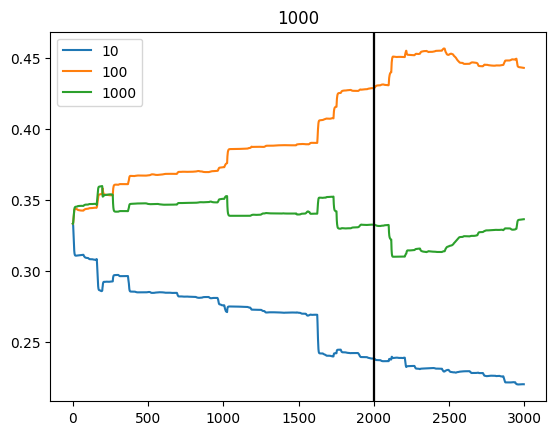

In [510]:
weights = single_result['all_weights']
interval_candidates = single_result['interval_candidates']
print(interval_candidates)

for i in range(len(weights[0])):
    plt.plot([x[i]/sum(x) for x in weights], label=str(interval_candidates[i]))
    plt.title(str(interval_candidates[i]))
    plt.axvline(shift_point-max(interval_candidates), color='black')
plt.legend()
plt.show()

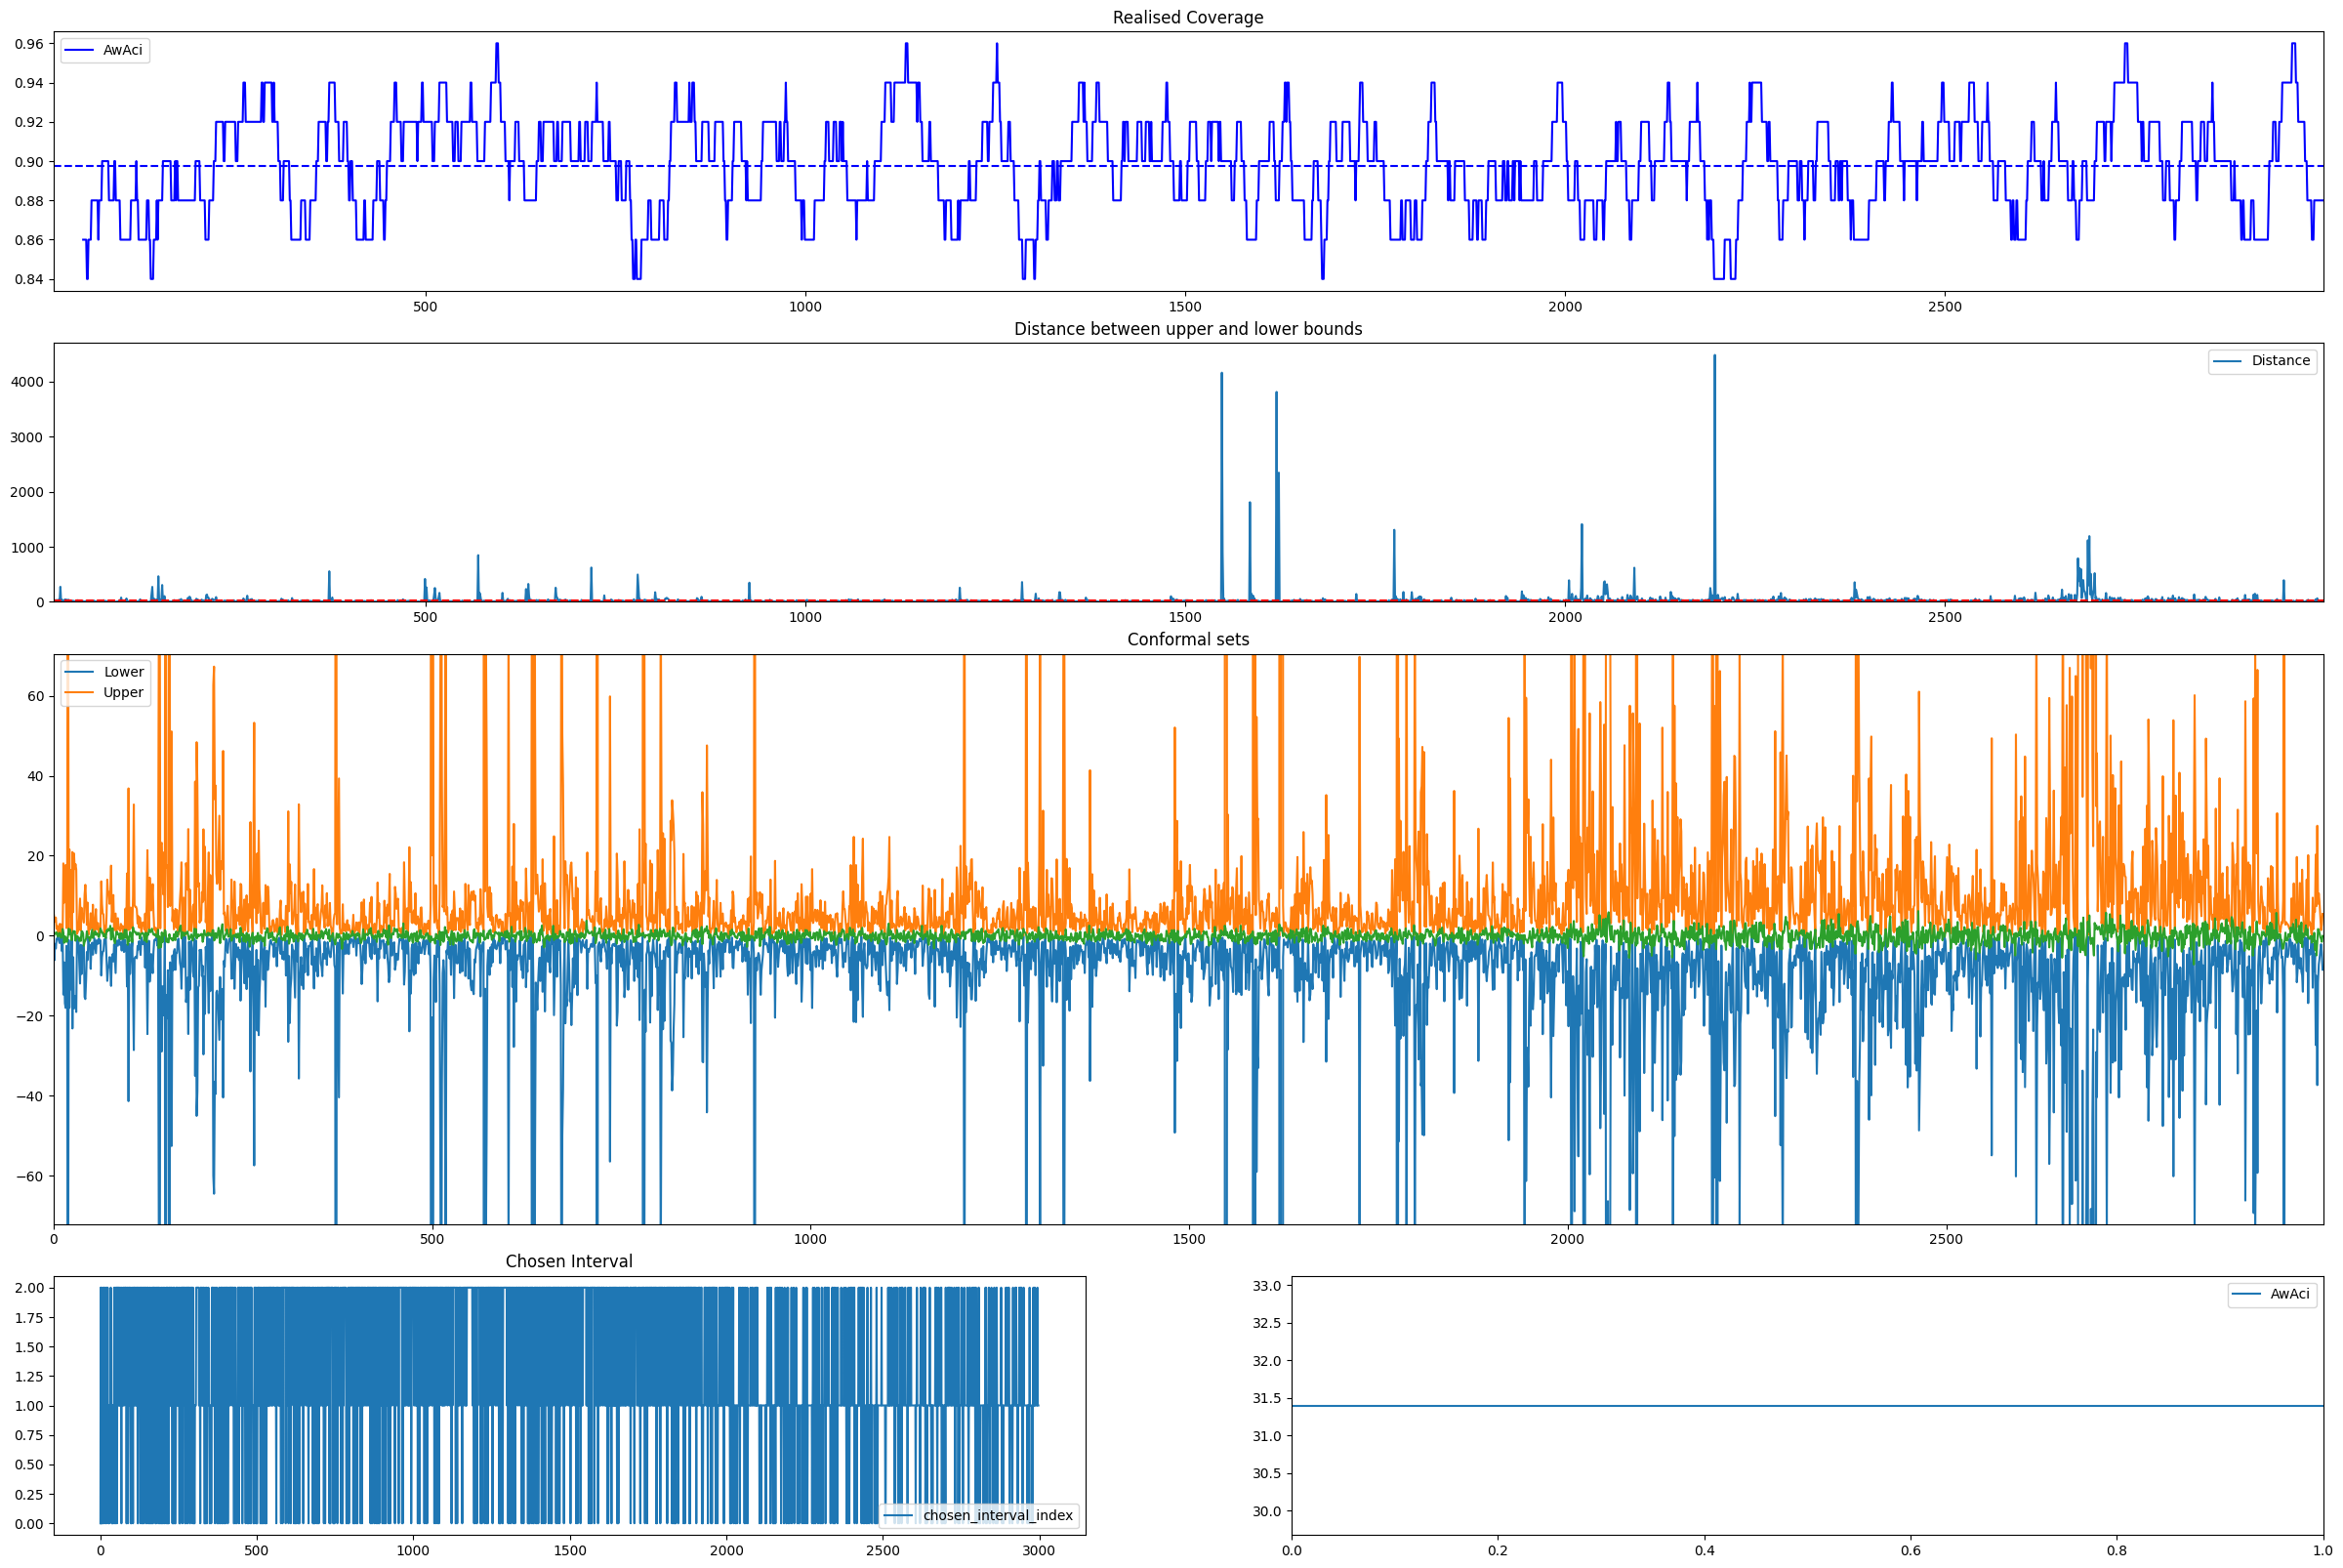

In [457]:
ACP_plots.AwDT_plot(single_result, single_shift[0], 0)

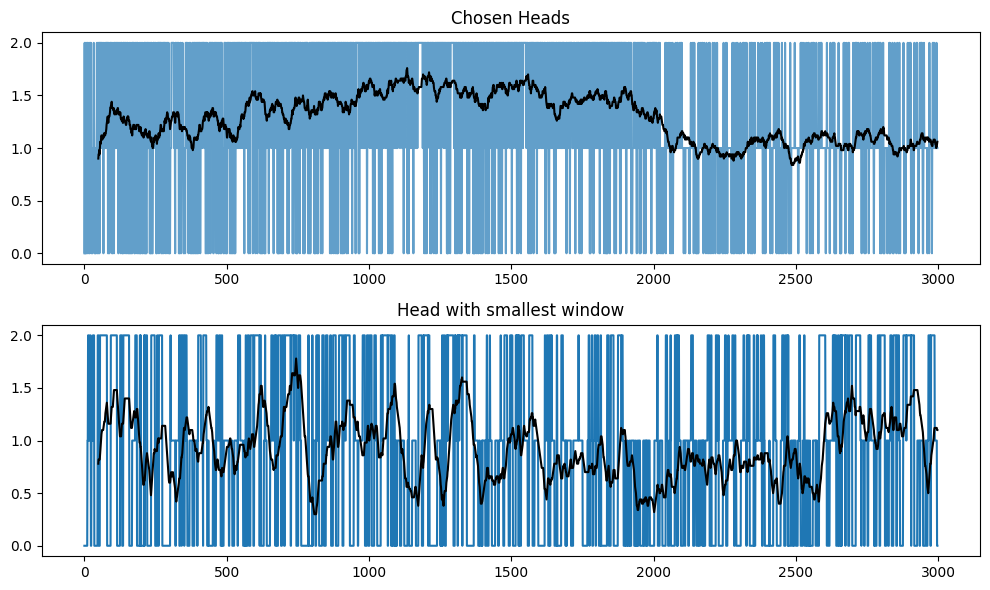

In [458]:
# Plotting the chosen heads vs the head with the lowest loss.
# Making the plots slightly transparent
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(single_result['chosen_interval_index'], alpha=0.7)
rolling_mean = pd.Series(single_result['chosen_interval_index']).rolling(50).mean()
plt.plot(rolling_mean, alpha=1, color='black')
plt.title('Chosen Heads')
plt.subplot(2, 1, 2)
plt.plot(np.array(single_result['all_head_radii']).argmin(axis=1), alpha=1)
rolling_mean = pd.Series(np.array(single_result['all_head_radii']).argmin(axis=1)).rolling(50).mean()
plt.plot(rolling_mean, alpha=1, color='black')
plt.title('Head with smallest window')
plt.tight_layout()
plt.show()


 Seems to perform better and is able to converge more convicly. To the set which it wants, however this doesnt seem to be explainable in terms of the way which you would like it to be. Wherby sometimes it still prefers old scores when new ones should be better it may be better to look at the losses during.

## Trying with pinball loss instead of set_loss

In [465]:
class pinball_AdaptiveCP(AdaptiveCP):
    def ACI_head(self, timeseries_data: tuple, gamma: float, start_point: int, custom_interval = None):
            xpred, y = timeseries_data
            alpha_t_list = [self.coverage_target]

            All_scores = self.score_function(xpred, y)

            err_t_list = []
            conformal_sets_list = []

            pinball_loss = self.vectorize_l()
            
            for i in range(start_point, len(All_scores)):
                Coverage_t = self.C_t(alpha_t_list[-1], All_scores, xpred[i], i, custom_interval)
                conformal_sets_list.append(Coverage_t)

                # Finding B_t
                low, high = 0, 999 
                possibilities = np.linspace(0, 1, 1000) # as 1 - 

                B_t = 1
                while low <= high:
                    mid = (high + low) // 2
                    possi = possibilities[mid]
                    Cpossi = self.C_t(possi, All_scores, xpred[i], i, custom_interval)

                    if Cpossi[0] < y[i] < Cpossi[1]:
                        B_t = possi
                        low = mid + 1
                    else:
                        high = mid - 1

                yield Coverage_t, pinball_loss(B_t, alpha_t_list[-1])

                error_t = AdaptiveCP.err_t(y[i], Coverage_t)
                err_t_list.append(error_t)

                alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
                alpha_t_list.append(alpha_t)

            return False
        
    def AwACI(self, timeseries_data: tuple, interval_candidates: np.array = None, nu_sigma: tuple = (10**-3, 0.05), gamma: float = 0.05, title: str = None):
            
            _, y = timeseries_data

            chosen_interval_index = []
            err_t_list = []
            conformal_sets_list = []
            optimal_radius_list = []
            chosen_radius_list = []
            all_interval_weights = []

            # Scale parameters, havent looked into scaling them best.
            sigma = nu_sigma[1]
            nu = nu_sigma[0] 

            if interval_candidates is None:
                interval_candidates = np.array(range(50, 550, 100))

            # To sync all of the heads we need to start at the max of all the candidates.
            start_point = max(interval_candidates) + 1
            i_count = start_point

            # Create the head and intitialse the weights.
            ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
            interval_weights = np.ones(len(interval_candidates))
            culmative_loss = np.zeros(len(interval_candidates))
            
            # Continues calculating intervals until one of the heads stops.
            none_terminated = True

            while none_terminated: 
                head_sets = [] # Will contain the result from each head.
                pinball_loss_list = [] # Will contain the B_t values for each head.
                
                # Create the mass distribution for each head

            
                try:
                    # Create a list of the coverages for the different heads.
                    for head in ACI_heads:
                            coverage, loss = next(head)
                            
                            head_sets.append(coverage)
                            pinball_loss_list.append(loss)

                except StopIteration: # One head is terminated.
                    none_terminated = False
                    break # You could but the return statement here

                # Choosing which head to use.
                chosen_set = random.choices(head_sets, weights=interval_weights, k=1)[0] # Using random module as numpy can not deal with tuples.

                # TIME FRONTIER -------------

                # Seeing whether result lies within the set.
                err_true = AdaptiveCP.err_t(y[i_count], chosen_set)

                # Calculating the loss.
                culmative_loss += np.array(pinball_loss_list)

                # Updating the weights.
                new_weights = interval_weights * np.exp(-1 * nu * culmative_loss) # log space
                final_weights = new_weights*(1-sigma) + (new_weights.mean() *sigma) # mean

                interval_weights = final_weights/sum(final_weights)


                # Incrementing the i-count
                i_count+=1

                err_t_list.append(err_true)
                conformal_sets_list.append(chosen_set)
                chosen_interval_index.append(head_sets.index(chosen_set))
                all_interval_weights.append(interval_weights)
                
            # Calculating different averages
            realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
            average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

            return {
                    'model': title if title is not None else 'pinball AwACI',
                    'coverage_target': self.coverage_target,
                    'interval_candidates': interval_candidates,
                    'realised_interval_coverage': realised_interval_coverage,
                    'average_prediction_interval': average_prediction_interval,
                    'optimal_set_radius': optimal_radius_list, 
                    'chosen_set_radius': chosen_radius_list,
                    'conformal_sets': conformal_sets_list,
                    'error_t_list': err_t_list,
                    'chosen_interval_index': chosen_interval_index,
                    'start_point': start_point,
                    'interval_size': 50,
                    'all_weights': all_interval_weights
                }

In [466]:
shift_point = 3000
single_shift = ACP_data.single_shift((0,1), (0, 2), 4000, shift_point)

pACP = pinball_AdaptiveCP(0.1)

In [483]:
single_result = pACP.AwACI(single_shift[0], interval_candidates=range(100,1000,100), nu_sigma=(10**0, 0.1), gamma=0.05)

range(100, 1000, 100)
0.8997048212528698
25.06634726592299


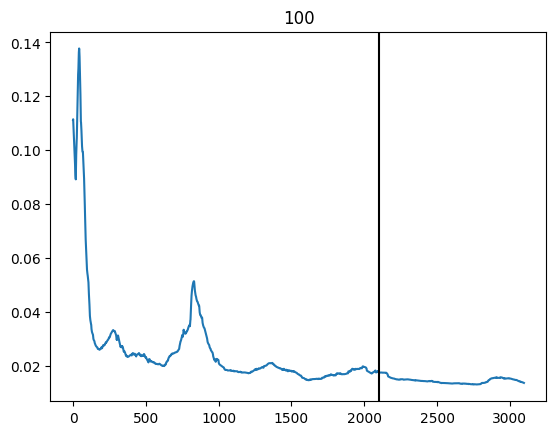

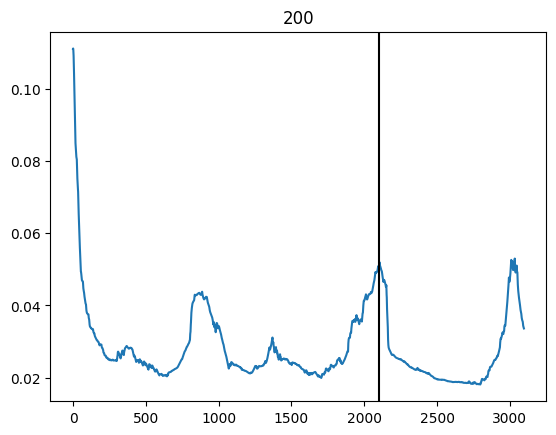

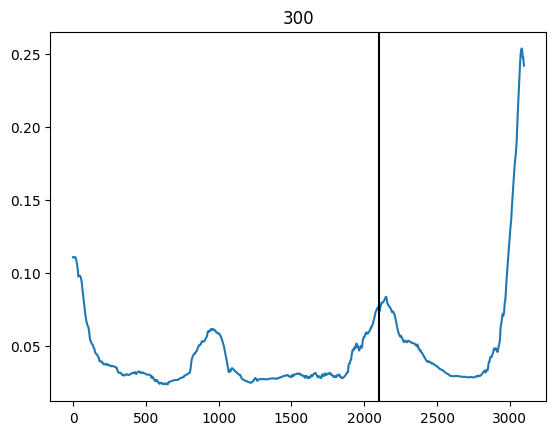

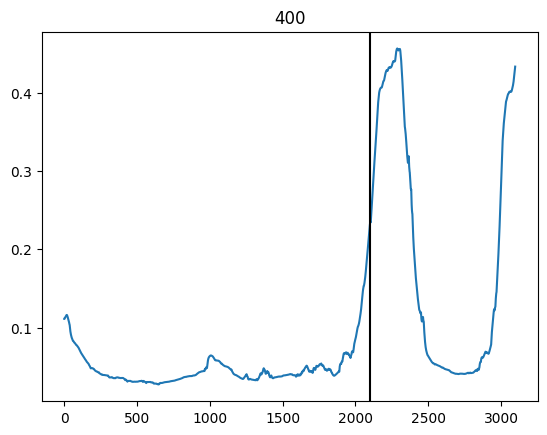

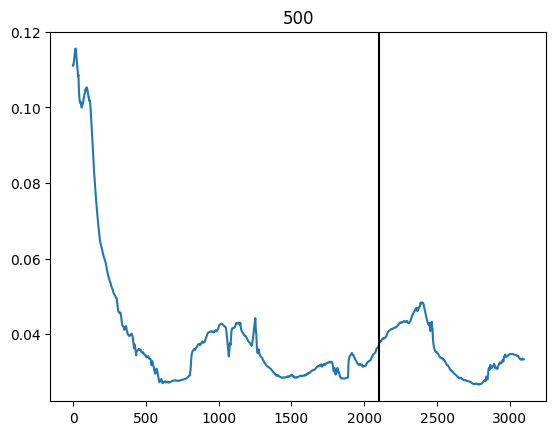

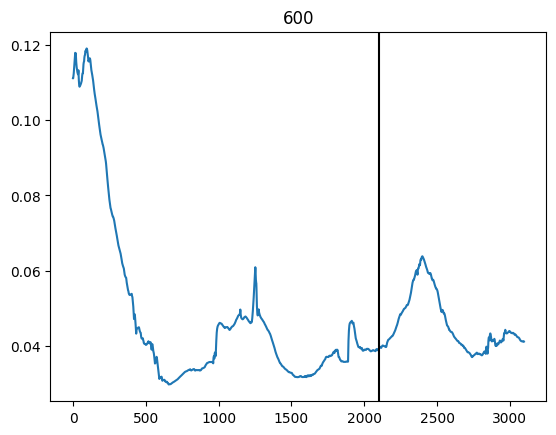

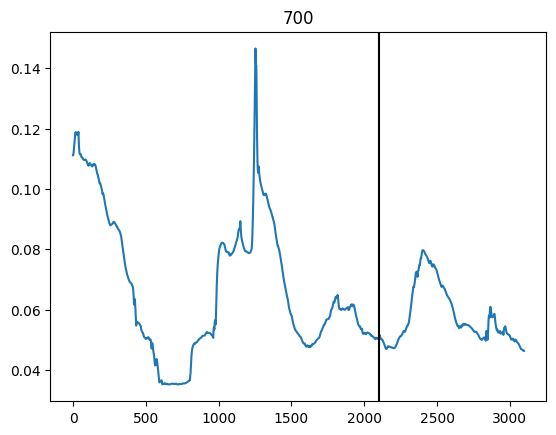

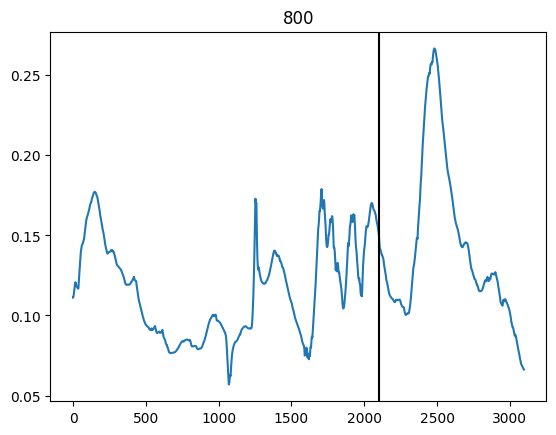

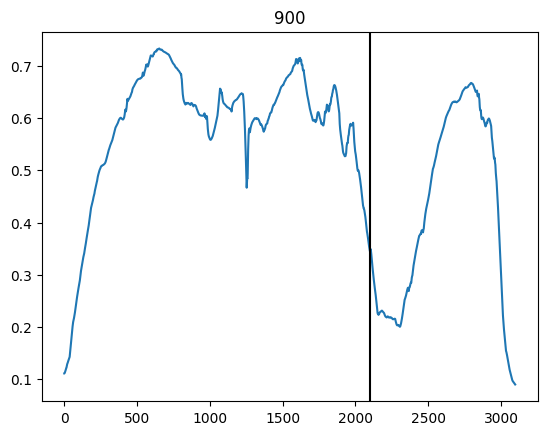

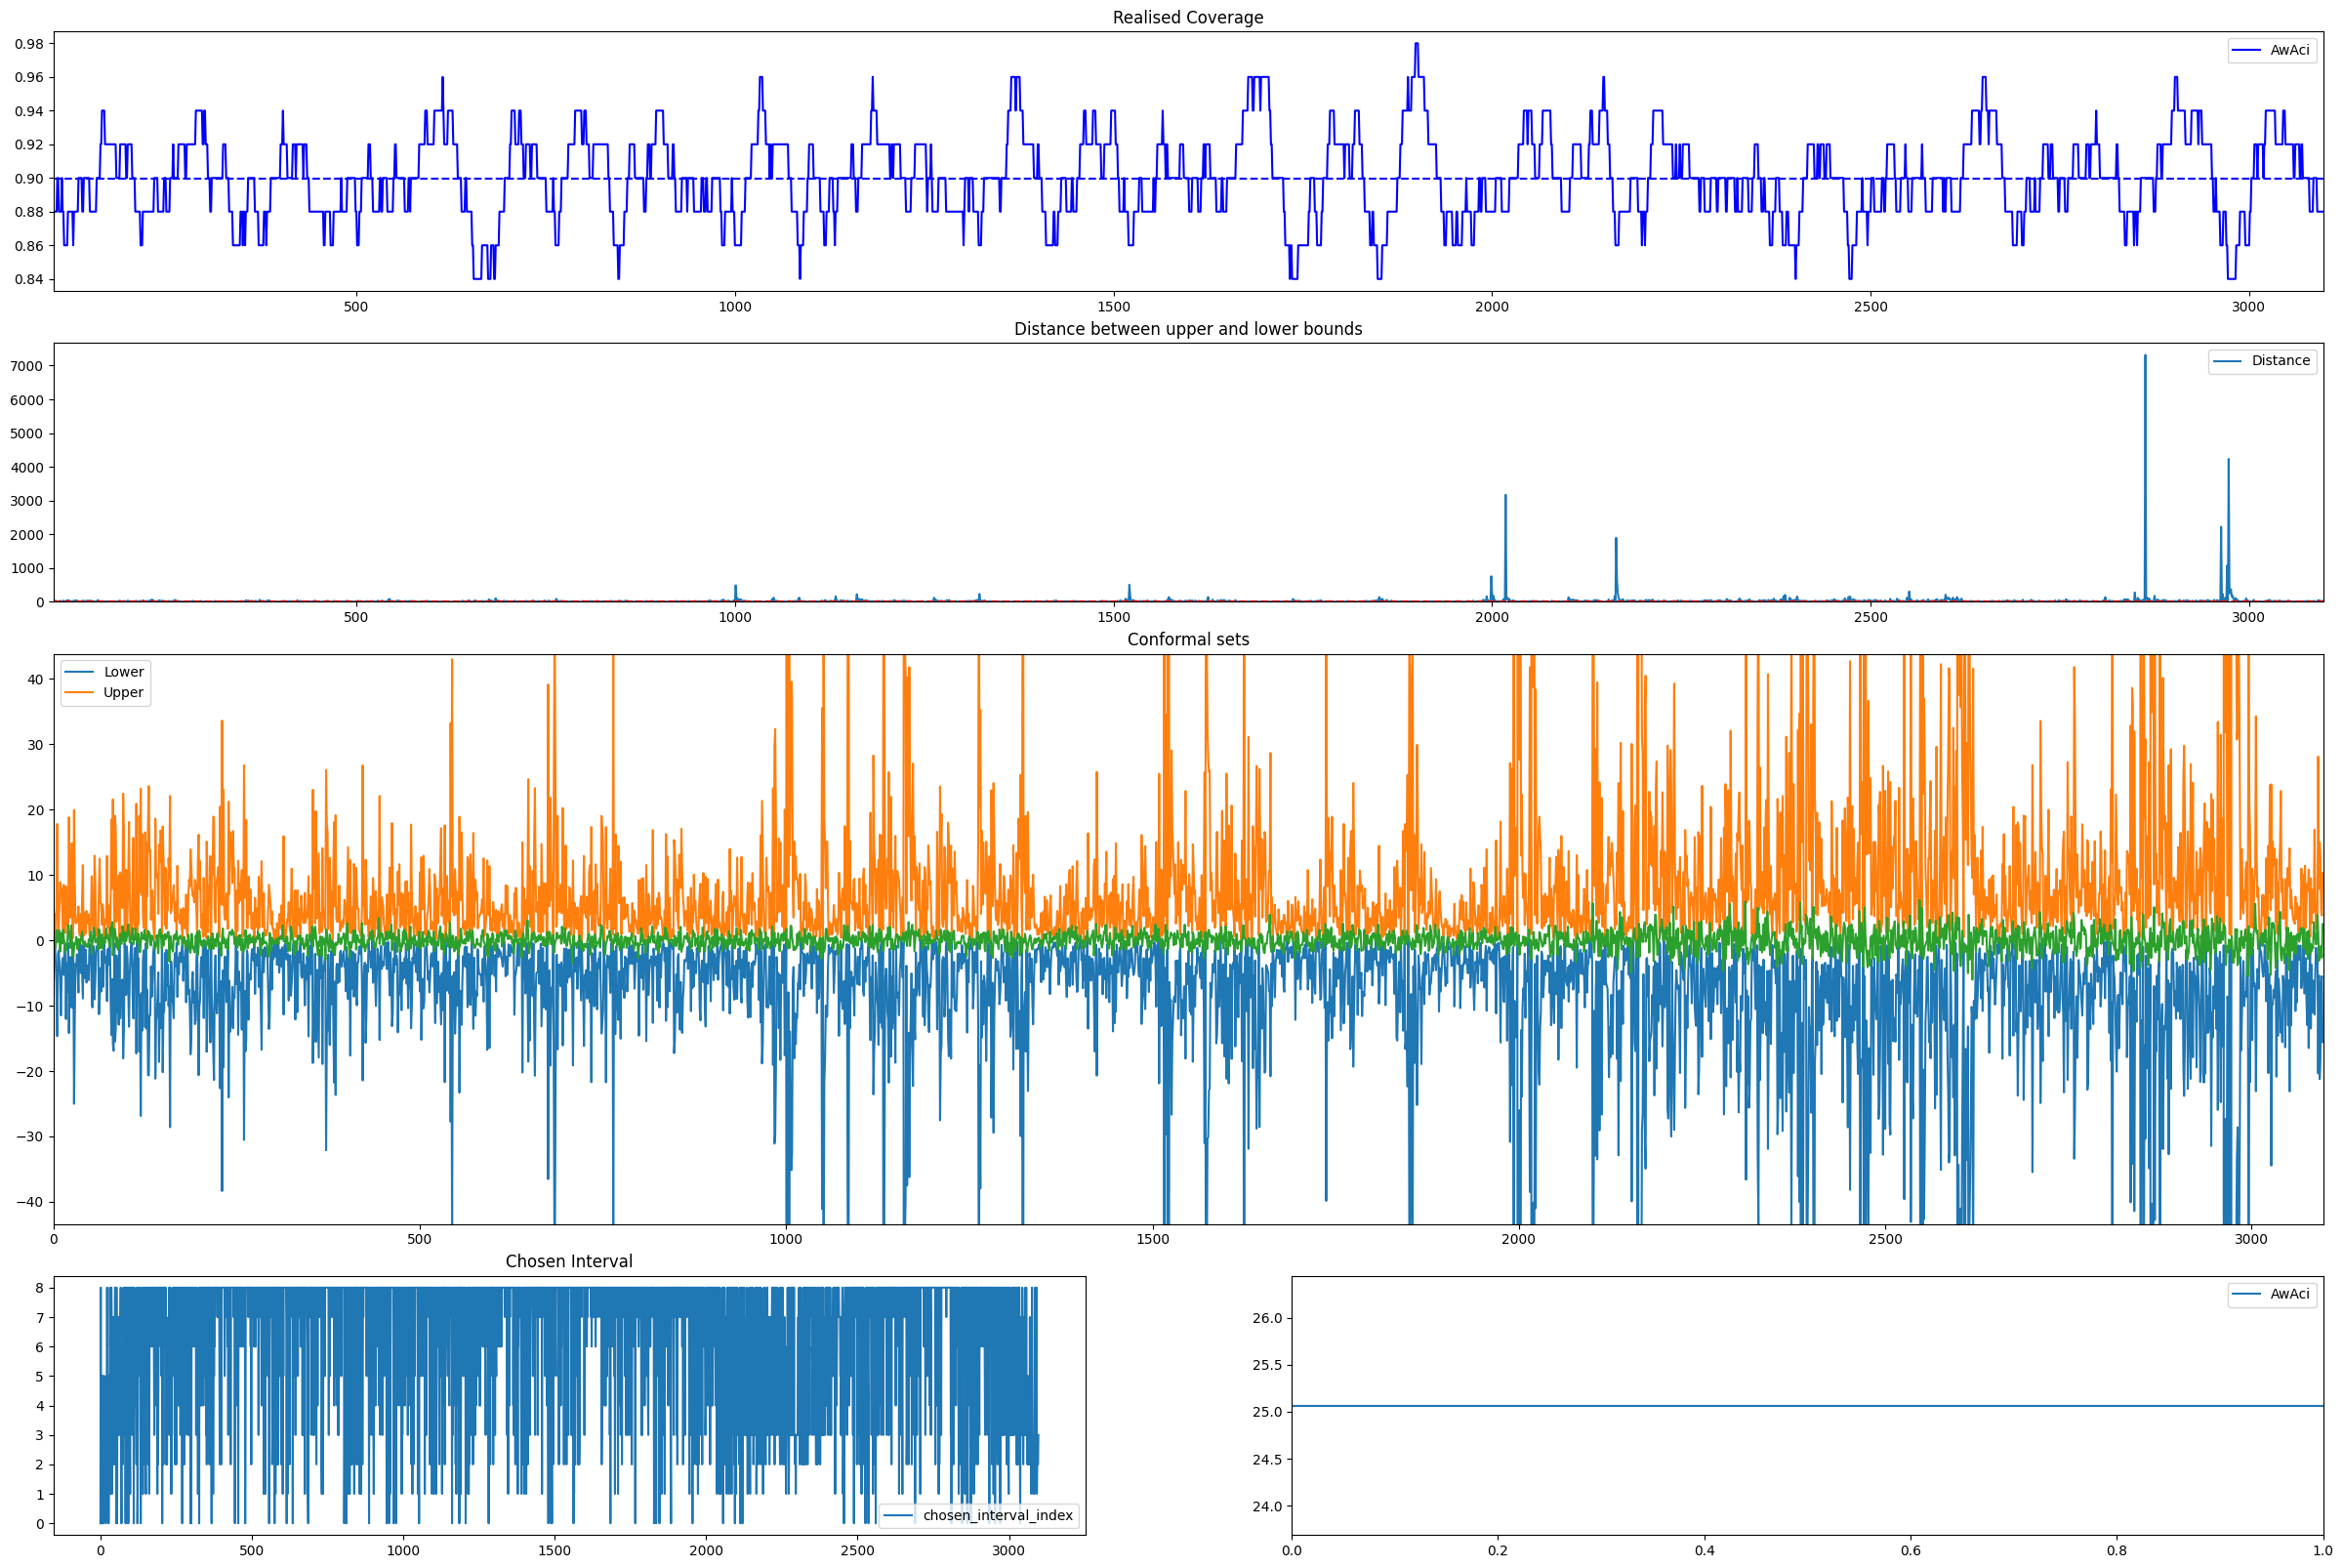

In [484]:
weights = single_result['all_weights']
interval_candidates = single_result['interval_candidates']
print(interval_candidates)
print(single_result['realised_interval_coverage'])
print(single_result['average_prediction_interval'])

for i in range(len(weights[0])):
    plt.plot([x[i]/sum(x) for x in weights])
    plt.title(str(interval_candidates[i]))
    plt.axvline(shift_point-max(interval_candidates), color='black')
    plt.show()
    
ACP_plots.AwDT_plot(single_result, single_shift[0], 0)

In [487]:
shift_point = 3000
single_shift = ACP_data.random_multi_shift(1, (5000,5001))

pACP = pinball_AdaptiveCP(0.1)

In [488]:
single_result = pACP.AwACI(single_shift[0], interval_candidates=range(100,1000,100), nu_sigma=(10**0, 0.1), gamma=0.05)

range(100, 1000, 100)
0.8988984934551741
184.43662641640861


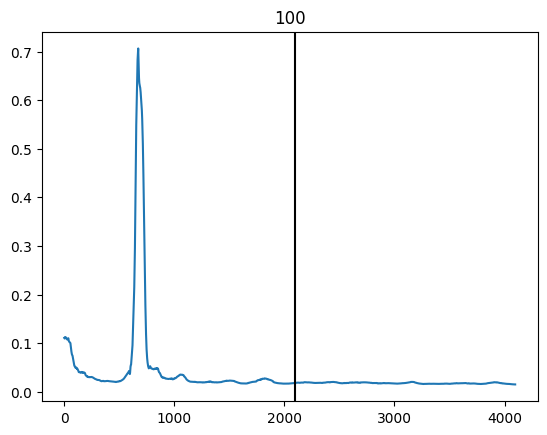

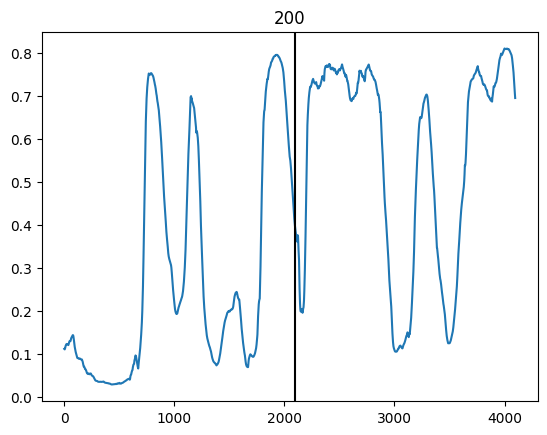

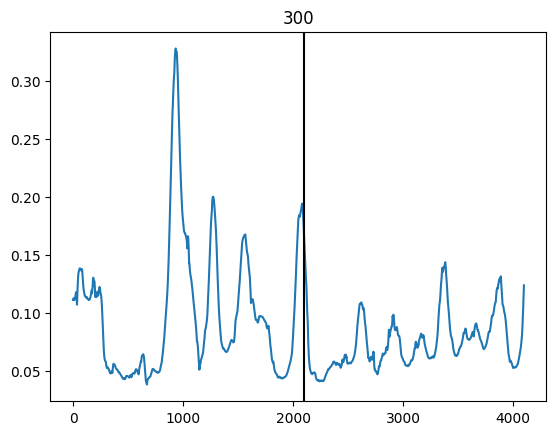

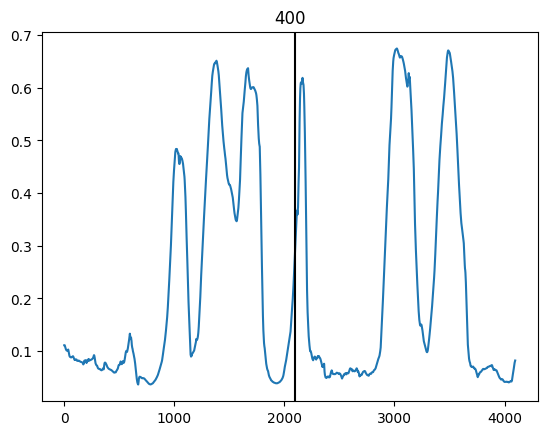

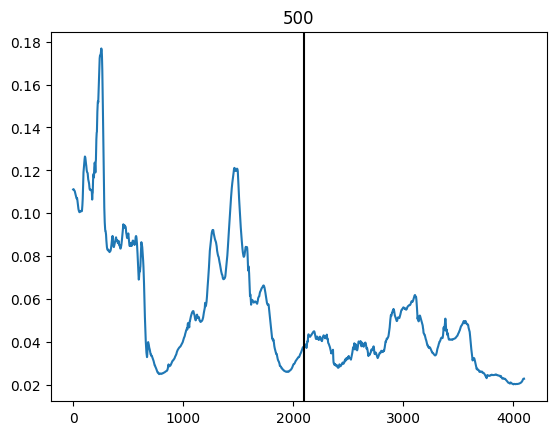

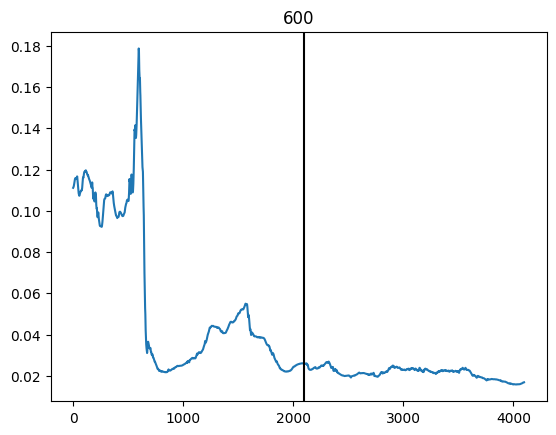

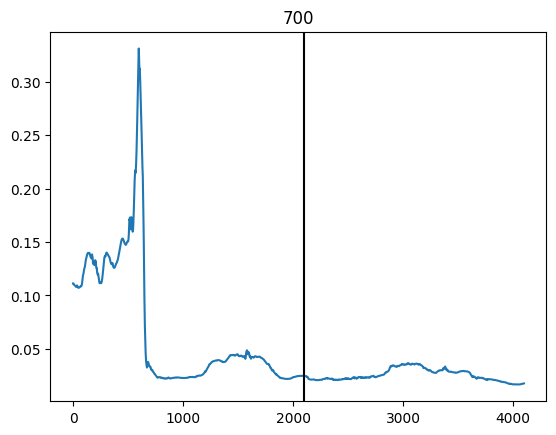

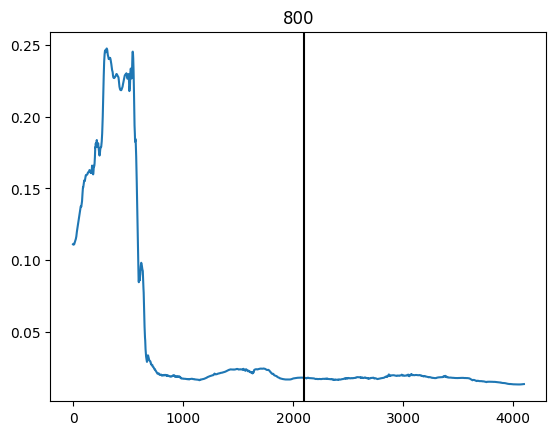

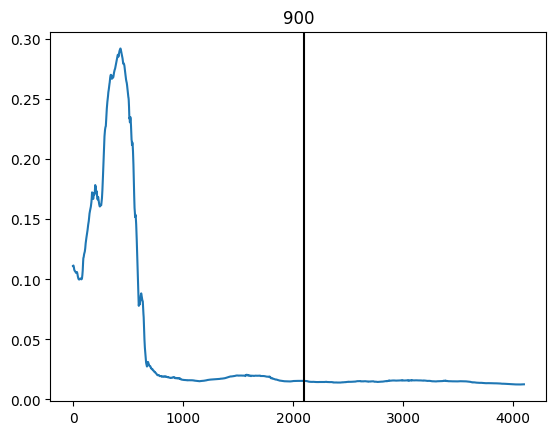

ValueError: probabilities contain NaN

In [490]:
weights = single_result['all_weights']
interval_candidates = single_result['interval_candidates']
print(interval_candidates)
print(single_result['realised_interval_coverage'])
print(single_result['average_prediction_interval'])

for i in range(len(weights[0])):
    plt.plot([x[i]/sum(x) for x in weights])
    plt.title(str(interval_candidates[i]))
    plt.axvline(shift_point-max(interval_candidates), color='black')
    plt.show()
    
ACP_plots.AwDT_plot(single_result, single_shift[0], 1)